## Import related functions

In [1]:
include("useful_func.jl")

FFT_power (generic function with 1 method)

In [ ]:
d=0.0001:0.0001:0.1
Nτ=0:0.05:2
ODE_eigen = zeros(Float64, length(Nτ), length(d))
PDE_eigen = zeros(Float64, length(Nτ), length(d))

for i in 1:length(d)
    for j in 1:length(Nτ)
        ODE_eigen[j,i], PDE_eigen[j,i], _ = ODE_PDE_system_2D(Nτ, 0.7, 2, 1, d[i], 3)[j]
    end
end

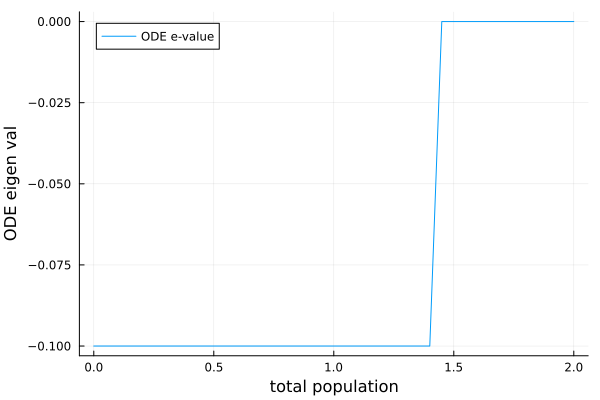

In [37]:
plot(Nτ, ODE_eigen[:,1], xlabel="total population", ylabel="ODE eigen val", label="ODE e-value")


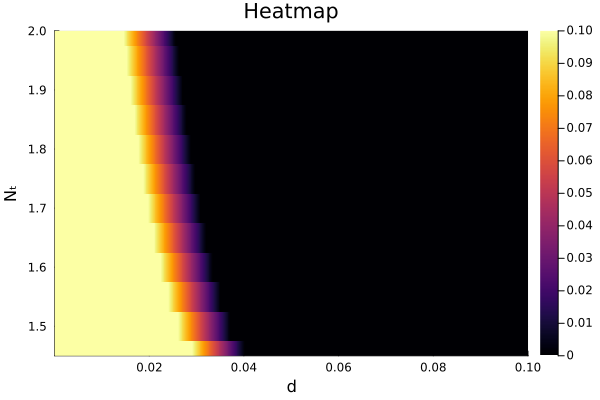

In [34]:
heatmap(d, Nτ, PDE_eigen,
    xlabel = "d",
    ylabel = "Nₜ",
    title = "Heatmap",  # Ensure aspect ratio is equal for clarity
    colorbar = true ,ylims = (1.45, 2),clim = (0, 0.1)
)


## Initial Conditions

In [39]:
## Pre-define the mode number k
k1=3
k2=5

function N_initial_cond(x)
    C₁=ODE_PDE_system(1.45,λ,ν,1,d,k1)[1][4][1]
    N = N̄+1e-4*C₁*cos(k*x)
    return(N)
end


function P_initial_cond(x)
    C₂=ODE_PDE_system(1.45,λ,ν,1,d,k2)[1][4][2]
    P = P̄+1e-4*C₂*cos(k*x)
    return(P)
end

P_initial_cond (generic function with 1 method)

In [2]:
## Pre-define the mode vector k
k_vec=[3,5]

function N_IC_general(x,k_vec)
    C_vec=zeros(length(k_vec))
    N=N̄
    for i in 1:length(C_vec)
        C_vec[i]=ODE_PDE_system(1.45,λ,ν,1,d,k_vec[i])[1][4][1]
        N=N+1e-4*C_vec[i]*cos(k_vec[i]*x)
    end
    return(N)
end

function N_IC_gen(x)
    N=N_IC_general(x,k_vec)
    return(N)
end


function P_IC_general(x,k_vec)
    C_vec=zeros(length(k_vec))
    P=P̄
    for i in 1:length(C_vec)
        C_vec[i]=ODE_PDE_system(1.45,λ,ν,1,d,k_vec[i])[1][4][2]
        P=P+1e-4*C_vec[i]*cos(k_vec[i]*x)
    end
    return(P)
end

function P_IC_gen(x)
    P=P_IC_general(x,k_vec)
    return(P)
end

P_IC_gen (generic function with 1 method)

In [22]:
function random_IC_N(x)
    noise = rand(Normal(0, 1e-3))
    return N̄ + noise
end

function random_IC_P(x)
    noise = rand(Normal(0, 1e-3))
    return P̄ + noise
end

random_IC_P (generic function with 1 method)

## Hyperparameter

In [23]:
λ,ν=0.7,2
d= 1e-4

## Notice that we pick total conserved population to be 1.45
N̄=equilibrium_state(1.45,λ,ν)[1][1]
P̄=equilibrium_state(1.45,λ,ν)[2][1];

## Initilize and Set up Model

In [24]:
## Initialize the model
NP_parameters =   (d_1= 1 ,
                   d_2= d ,
                   ν = ν ,          
                   λ = λ
)



growth(z, t, N, P, params) = params.ν * P * N / (N + 1)
death(z,t,N,P,params)=params.λ*(max(0, P))^(1/2)


N_reaction(z, t, N, P,  params) = - growth( z, t, N, P,  params) + death(z,t,N,P,params)
P_reaction(z, t, N, P, params) =   growth( z, t, N, P, params)  - death(z,t,N,P,params)


N_forcing = Forcing(N_reaction, field_dependencies = (:N, :P), parameters = NP_parameters)
P_forcing = Forcing(P_reaction, field_dependencies = (:N, :P ), parameters = NP_parameters)


grid    = RectilinearGrid(size=128, z=(0,2*π), topology=(Flat, Flat, Bounded))

diffusivities = NamedTuple{(:N, :P)}((NP_parameters.d_1, NP_parameters.d_2))

closure = ScalarDiffusivity(κ=diffusivities)

model   = NonhydrostaticModel(; grid, 
                             closure, 
                             tracers = (:N, :P),
                             forcing = (N=N_forcing, P=P_forcing)
                             )

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 1×1×128 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: Centered(order=2)
├── tracers: (N, P)
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=(N=1.0, P=0.0001))
├── buoyancy: Nothing
└── coriolis: Nothing

In [25]:
## Decide our initial condition
set!(model, N = random_IC_N, P = random_IC_P)
min_Δz = minimum_zspacing(model.grid)
diffusion_time_scale = min_Δz^2 / model.closure.κ.N

0.0024095713869847065

## Simulation

In [26]:
## Running simulation
max_time=60
simulation = Simulation(model, Δt = 0.1 * diffusion_time_scale, stop_time = max_time)

########################################

N, P = model.tracers

perturbation_N(args...) = norm(N .- N̄)
perturbation_P(args...) = norm(P .- P̄)

simulation.output_writers[:growth_NP] =
    NetCDFOutputWriter(model, (; perturbation_N, perturbation_P);
                     filename = "NPgrowth.nc",
                     schedule = IterationInterval(10),
                     dimensions = (; perturbation_N = (),
                                     perturbation_P = ()),
                     overwrite_existing = true)

simulation.output_writers[:fields] =
    JLD2OutputWriter(model, model.tracers,
                     filename = "NP.jld2",
                     schedule=IterationInterval(200),
                     overwrite_existing = true)

run!(simulation)

┌ Warning: Overwriting existing d:\Master Research\Research-Project\NPgrowth.nc.
└ @ Oceananigans.OutputWriters C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\OutputWriters\netcdf_output_writer.jl:397
┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:195
┌ Info:     ... simulation initialization complete (1.056 seconds)
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:239
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:123
┌ Info:     ... initial time step complete (874.930 ms).
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\run.jl:132
┌ Info: Simulation is stopping after running for 17.053 minutes.
└ @ Oceananigans.Simulations C:\Users\xiang\.julia\packages\Oceananigans\Y6Lmd\src\Simulations\simulation

## Visualize Result

In [31]:
N_data,P_data,times,space=key_variable_outcome(18,model,"NP.jld2");

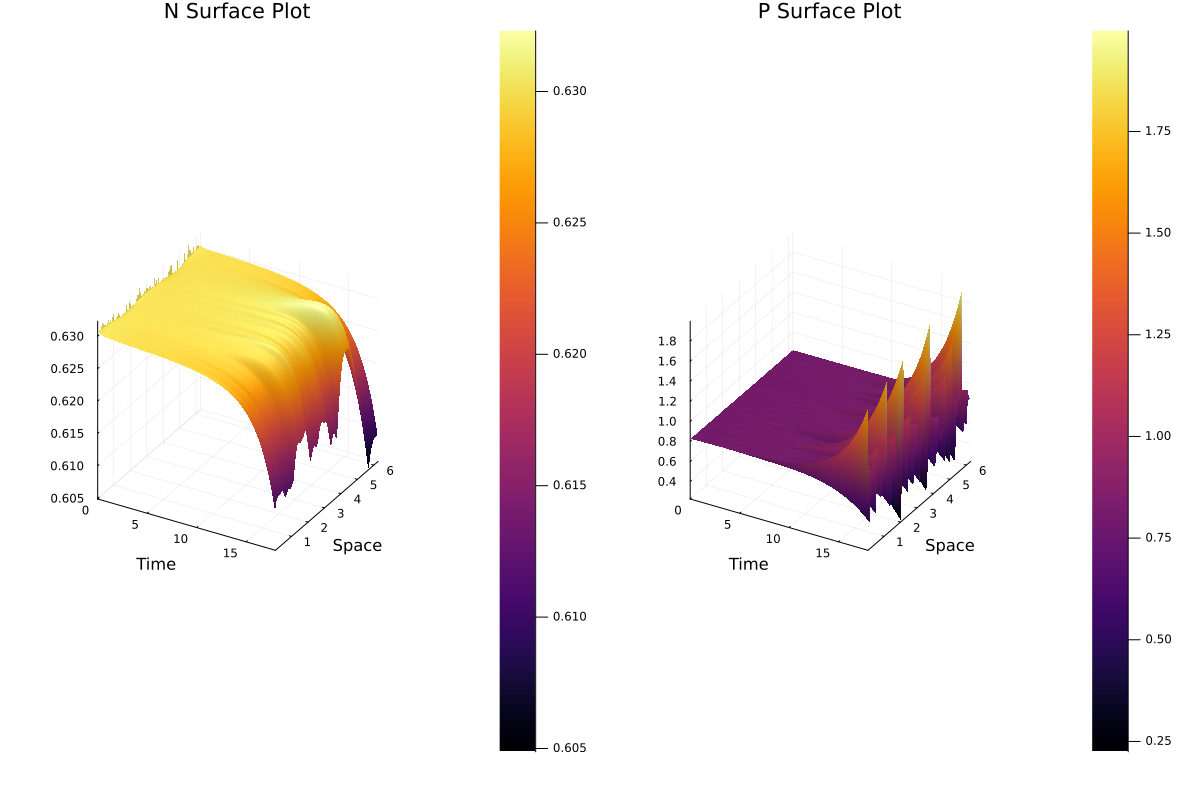

In [32]:
surface_plot(N_data,P_data,times,space)

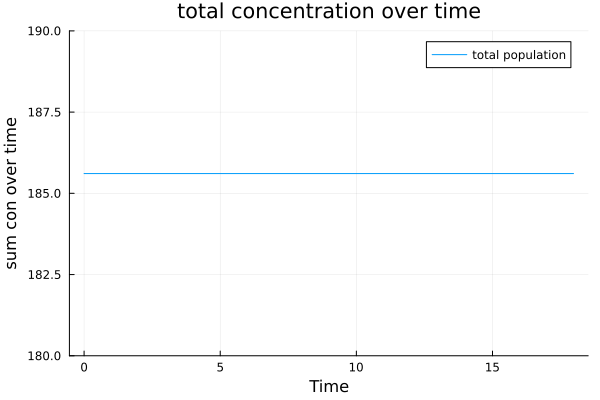

In [33]:
conservation_plot(N_data,P_data,times,space)

Growth rate of N is approximately 0.26028891597233
Growth rate of P is approximately 0.3247987594556776


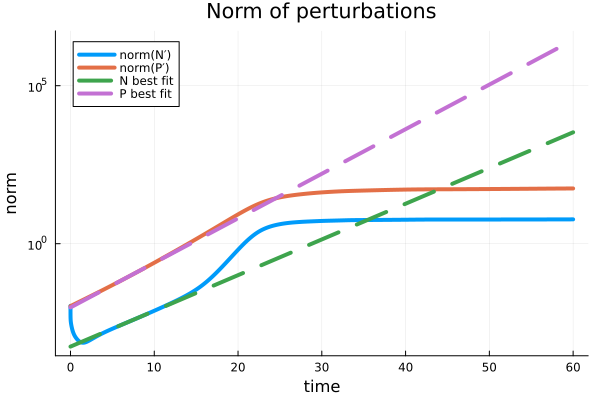

In [35]:
experiment_growth_rate("NPgrowth.nc",N̄,P̄)

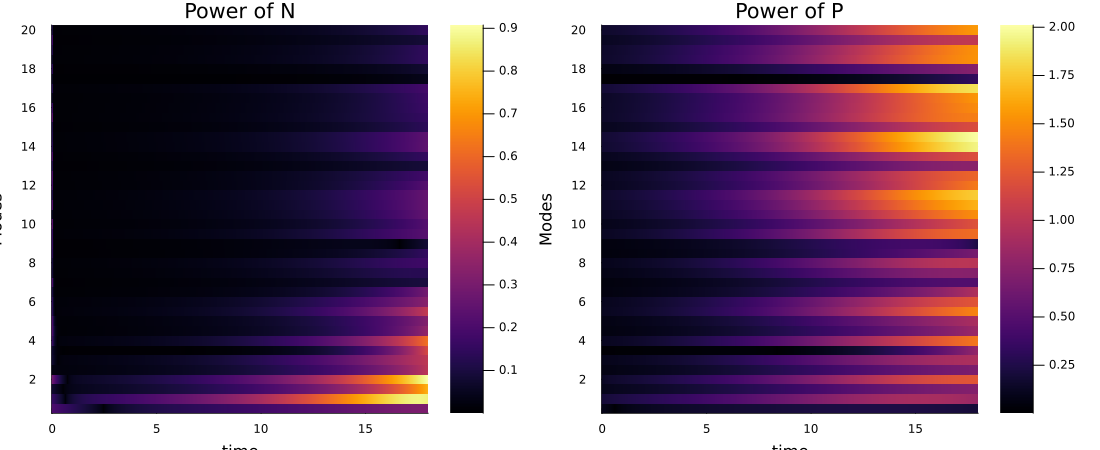

In [36]:
FFT_power(N_data, P_data, times)